# IFT6135 Assignment 3
## Neural Turing Machines
### Roger Girgis, Alejandro Posada, and Matthew Scicluna

## Filling in the gaps

### Transformation Functions

We implemented the Neural Turing machine described in [1]. The goal was to better understand attention and memory augmented networks, and the difficulties encountered when training them.

The output of the controller was a $100$ dimensional vector which we transformed into parameters used in the read and write heads and attention mechanism through single layer networks with different output tranformations. We chose output transformations such that their ranges matched the constraints of the parameters as described in the paper. We note that the choice in output tranformations matched those found in most implementations of Neural turing machines. If we denote as $M$ the size of the memory vector and $K$ as the allowed integer shift of the location based attentional mechanism, then the choice of transformation for each parameter can be found in the following table:

| Parameter    |Domain                        | Activation                |
|--------------|------------------------------|---------------------------|
| $\beta$      | $(0,\infty)$                 |  Softplus                 |
| $\kappa$     | $\mathbb{R}^M$               |  Identity                 |          
| $\gamma$     | $(1, \infty)$                |  1 + Softplus             |          
| $g$          | $(0,1)$                      |  Sigmoid                  |          
| $s$          |probablity simplex of size $K$|  Softmax$\circ$Softplus   |          
| $e$          | $\mathbb{R}^M$               |  Sigmoid                  |          
| $a$          | $\mathbb{R}^M$               |  Sigmoid                  |          

### Diagram

(b) Present a diagram showing how you think the following are dependent on each other.

INSERT DIAGRAM HERE

* the input $x_t$
* the memory $M_{t-1}$ and $M_t$
* the output of the read head $r_{t-1}$ and $r_t$
* the erase and add vectors $e_t$ and $a_t$
* the output of the controller $o_t$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from visualize_results import visualize_sequence, plot_cost, plot_loss
import warnings
warnings.filterwarnings('ignore')

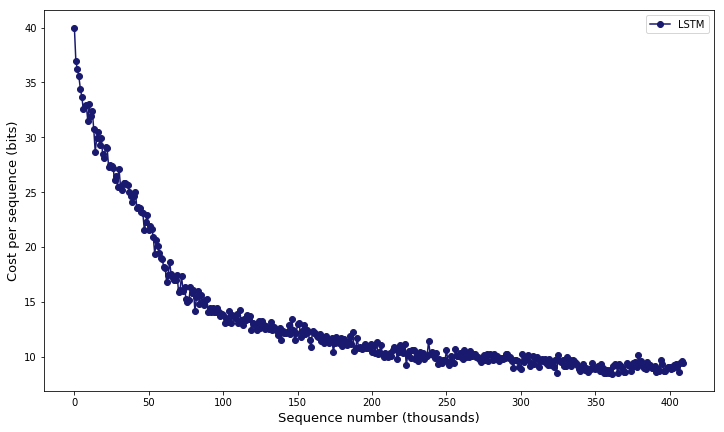

In [4]:
checkpoint = 'checkpoints/lstm/copy-batch-410000.0.model'
fig, ax = plt.subplots(figsize=(12, 7)) # passed as argument so we can plot the 3 curves in the same figure later
plot_cost(checkpoint, 'LSTM', fig=fig, ax=ax)
plt.show()

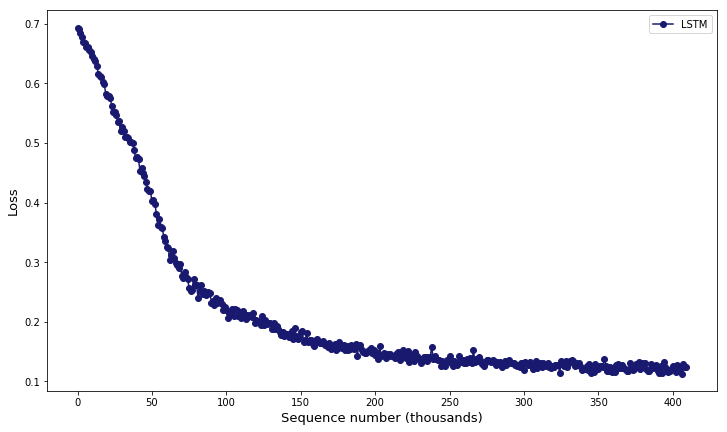

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))
plot_loss(checkpoint, 'LSTM', fig=fig, ax=ax)
plt.show()

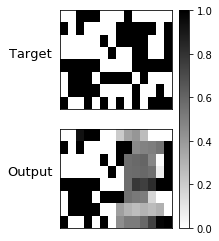

In [4]:
visualize_sequence(checkpoint, 'LSTM', seq_len=15)

## Shift Operator and Convolutions
The shift operator is a $1$ dimensional convolution with size equal to the number of allowed integer shifts.
We modify the code-base so that the shift operator only allows forward shifts. The original code is as follows:

In [2]:
def shift_convolve(self, w_s, s, int_shift):
    window_length = int_shift*2 + 1
    assert s.size(0) == window_length
    t = torch.cat([w_s[-window_length+1:], w_s, w_s[:window_length-1]])
    c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
    return c[int_shift:-int_shift]

The code modified to only allow forward shifts is as follows:

In [3]:
def shift_convolve_forward(self, w_s, s, int_shift):
    window_length = int_shift + 1
    assert s.size(0) == window_length
    t = torch.cat([w_s, w_s[:window_length-1]])
    c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
    return c

In [ ]:
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import numpy as np

w_s = Variable(torch.FloatTensor(np.arange(7)))
int_shift = 1

s = Variable(torch.ones(2*int_shift+1)/(2*int_shift+1))
new_ws = shift_convolve(None, w_s, s, int_shift)
print(w_s.data)
print(new_ws.data)
# w_s convolved in both directions, and so middle values unchanged

s = Variable(torch.ones(int_shift+1)/(int_shift+1))
new_ws = shift_convolve_forward(None, w_s, s, int_shift)
print(w_s.data)
print(new_ws.data)
# w_s convolved only in forward direction and so middle values increase by 0.5

AssertionError: 

## References

[1] Alex Graves, Greg Wayne, and Ivo Danihelka. Neural turing machines. arXiv preprint
arXiv :1410.5401, 2014.